데이터 전처리 시작!
원본 데이터 로딩 완료
transaction_data: 2,595,732건
coupon: 124,548건
=== 데이터 정제 시작 ===

1. 쿠폰 중복 제거:
  제거 전: 124,548건
  제거 후: 119,384건
  제거된 중복: 5,164건

2. 거래 데이터 정제:
  원본: 2,595,732건
  취소/환불 거래: 14,466건
  음수 수량: 0건
  음수 금액: 0건
  정제 후: 2,581,266건
  제거된 거래: 14,466건
=== 아웃라이어 분석 ===

거래금액 분포:
  95%ile: $7.99
  99%ile: $20.00
  최대값: $840.00
  99%ile 초과: 25,167건 (0.97%)

수량 분포:
  99%ile: 10
  최대값: 89638
  99%ile 초과: 25,406건
=== 아웃라이어 처리 ===
제거 기준:
  거래금액 > $29.01
  수량 > 10034

최종 거래 데이터:
  정제 전: 2,595,732건
  정제 후: 2,564,222건
  제거율: 1.21%
=== 무료 상품 분석 ===
무료 상품 거래: 4,451건
무료 상품을 받은 가구: 1476개

무료 상품 상위 카테고리:
DEPARTMENT
GROCERY           1198
MEAT-PCKGD         938
DRUG GM            662
COUP/STR & MFG     444
PASTRY             443
Name: count, dtype: int64
=== 데이터 통합 ===
상품 정보 결합: 2,564,222건
인구통계 결합: 2,564,222건
인구통계 커버리지: 1,408,449건 (54.9%)

정제된 데이터 저장 완료:
  transaction_clean.csv: 2,564,222건
  coupon_clean.csv: 119,384건
  transaction_with_product.csv: 2,564,222건
  transaction_with_demo.cs

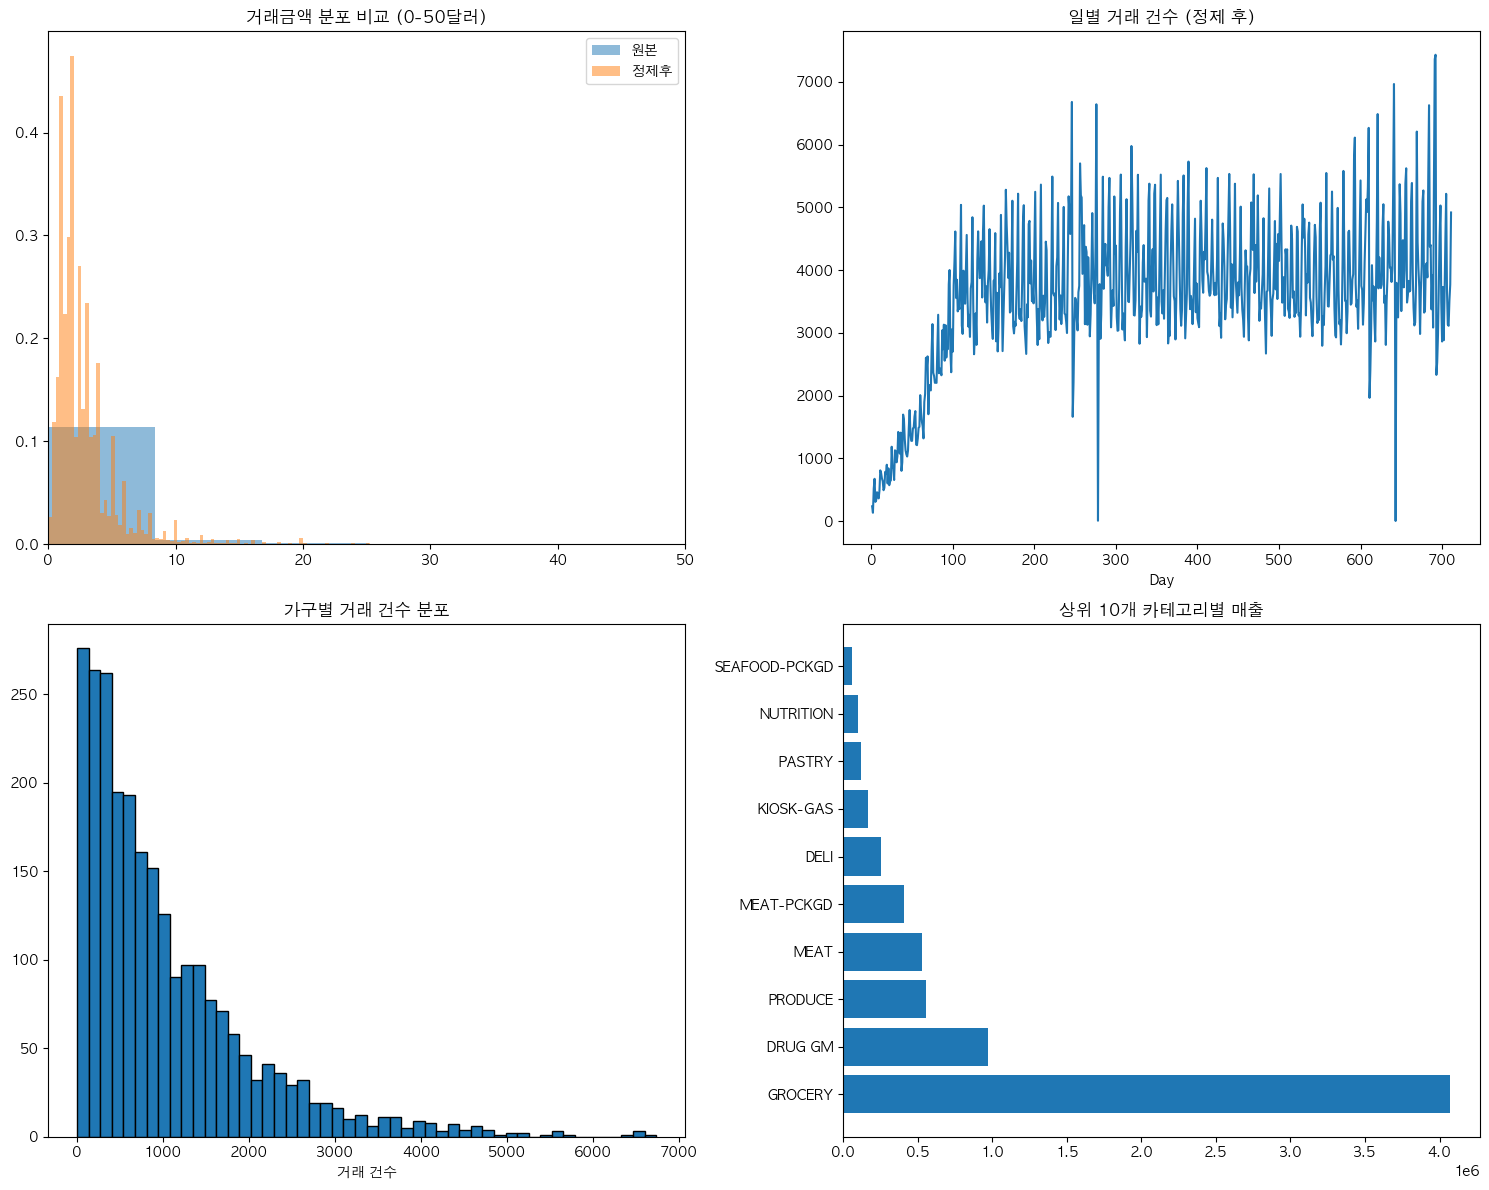

=== 데이터 전처리 완료 ===
다음 단계: 03_feature_engineering.ipynb
나이브 베이즈를 위한 고객 특성 변수 생성


In [1]:
# %%
# 데이터 전처리 - Naive Bayes Customer Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("데이터 전처리 시작!")

# %%
# 1. 데이터 로딩 (탐색에서 발견한 이슈들 적용)
data_path = '../data/raw/'

# 원본 데이터 로딩
coupon = pd.read_csv(f'{data_path}coupon.csv')
transaction_data = pd.read_csv(f'{data_path}transaction_data.csv')
hh_demographic = pd.read_csv(f'{data_path}hh_demographic.csv')
product = pd.read_csv(f'{data_path}product.csv')
campaign_table = pd.read_csv(f'{data_path}campaign_table.csv')

print("원본 데이터 로딩 완료")
print(f"transaction_data: {len(transaction_data):,}건")
print(f"coupon: {len(coupon):,}건")

# %%
# 2. 데이터 정제

print("=== 데이터 정제 시작 ===")

# 2-1. 쿠폰 중복 제거
print(f"\n1. 쿠폰 중복 제거:")
print(f"  제거 전: {len(coupon):,}건")
coupon_clean = coupon.drop_duplicates()
print(f"  제거 후: {len(coupon_clean):,}건")
print(f"  제거된 중복: {len(coupon) - len(coupon_clean):,}건")

# 2-2. 거래 데이터 정제
print(f"\n2. 거래 데이터 정제:")
print(f"  원본: {len(transaction_data):,}건")

# 취소/환불 거래 제거 (QUANTITY = 0)
cancellation_mask = transaction_data['QUANTITY'] == 0
cancellations = transaction_data[cancellation_mask]
print(f"  취소/환불 거래: {len(cancellations):,}건")

# 음수 값 확인
negative_quantity = transaction_data[transaction_data['QUANTITY'] < 0]
negative_sales = transaction_data[transaction_data['SALES_VALUE'] < 0]
print(f"  음수 수량: {len(negative_quantity):,}건")
print(f"  음수 금액: {len(negative_sales):,}건")

# 정상 거래만 필터링
transaction_clean = transaction_data[
    (transaction_data['QUANTITY'] > 0) & 
    (transaction_data['SALES_VALUE'] >= 0)
].copy()

print(f"  정제 후: {len(transaction_clean):,}건")
print(f"  제거된 거래: {len(transaction_data) - len(transaction_clean):,}건")

# %%
# 3. 아웃라이어 분석 및 처리

print("=== 아웃라이어 분석 ===")

# 3-1. 거래금액 아웃라이어
sales_q99 = transaction_clean['SALES_VALUE'].quantile(0.99)
sales_q95 = transaction_clean['SALES_VALUE'].quantile(0.95)
sales_max = transaction_clean['SALES_VALUE'].max()

print(f"\n거래금액 분포:")
print(f"  95%ile: ${sales_q95:.2f}")
print(f"  99%ile: ${sales_q99:.2f}")
print(f"  최대값: ${sales_max:.2f}")

# 극단적 아웃라이어 확인 (99%ile 초과)
extreme_sales = transaction_clean[transaction_clean['SALES_VALUE'] > sales_q99]
print(f"  99%ile 초과: {len(extreme_sales):,}건 ({len(extreme_sales)/len(transaction_clean)*100:.2f}%)")

# 3-2. 수량 아웃라이어
quantity_q99 = transaction_clean['QUANTITY'].quantile(0.99)
quantity_max = transaction_clean['QUANTITY'].max()

print(f"\n수량 분포:")
print(f"  99%ile: {quantity_q99:.0f}")
print(f"  최대값: {quantity_max:.0f}")

extreme_quantity = transaction_clean[transaction_clean['QUANTITY'] > quantity_q99]
print(f"  99%ile 초과: {len(extreme_quantity):,}건")

# %%
# 4. 아웃라이어 처리 전략

print("=== 아웃라이어 처리 ===")

# 극단적 아웃라이어만 제거 (99.5%ile 초과)
sales_q995 = transaction_clean['SALES_VALUE'].quantile(0.995)
quantity_q995 = transaction_clean['QUANTITY'].quantile(0.995)

print(f"제거 기준:")
print(f"  거래금액 > ${sales_q995:.2f}")
print(f"  수량 > {quantity_q995:.0f}")

# 필터링
outlier_mask = (
    (transaction_clean['SALES_VALUE'] <= sales_q995) & 
    (transaction_clean['QUANTITY'] <= quantity_q995)
)

transaction_final = transaction_clean[outlier_mask].copy()

print(f"\n최종 거래 데이터:")
print(f"  정제 전: {len(transaction_data):,}건")
print(f"  정제 후: {len(transaction_final):,}건")
print(f"  제거율: {(1 - len(transaction_final)/len(transaction_data))*100:.2f}%")

# %%
# 5. 무료 상품 분석 (나이브 베이즈에 중요한 특성)

print("=== 무료 상품 분석 ===")

free_products = transaction_final[transaction_final['SALES_VALUE'] == 0]
print(f"무료 상품 거래: {len(free_products):,}건")
print(f"무료 상품을 받은 가구: {free_products['household_key'].nunique()}개")

if len(free_products) > 0:
    print("\n무료 상품 상위 카테고리:")
    free_with_product = free_products.merge(product, on='PRODUCT_ID')
    print(free_with_product['DEPARTMENT'].value_counts().head())

# %%
# 6. 데이터 통합 및 저장

print("=== 데이터 통합 ===")

# 6-1. 거래 데이터에 상품 정보 결합
transaction_with_product = transaction_final.merge(
    product[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC']], 
    on='PRODUCT_ID', 
    how='left'
)

print(f"상품 정보 결합: {len(transaction_with_product):,}건")

# 6-2. 인구통계 정보 결합 (선택적)
transaction_with_demo = transaction_with_product.merge(
    hh_demographic, 
    on='household_key', 
    how='left'
)

print(f"인구통계 결합: {len(transaction_with_demo):,}건")

# 인구통계 커버리지 확인
demo_coverage = transaction_with_demo['AGE_DESC'].notna().sum()
print(f"인구통계 커버리지: {demo_coverage:,}건 ({demo_coverage/len(transaction_with_demo)*100:.1f}%)")

# %%
# 7. 정제된 데이터 저장

processed_path = '../data/processed/'

# 정제된 데이터 저장
transaction_final.to_csv(f'{processed_path}transaction_clean.csv', index=False)
coupon_clean.to_csv(f'{processed_path}coupon_clean.csv', index=False)
transaction_with_product.to_csv(f'{processed_path}transaction_with_product.csv', index=False)
transaction_with_demo.to_csv(f'{processed_path}transaction_with_demo.csv', index=False)

print(f"\n정제된 데이터 저장 완료:")
print(f"  transaction_clean.csv: {len(transaction_final):,}건")
print(f"  coupon_clean.csv: {len(coupon_clean):,}건")
print(f"  transaction_with_product.csv: {len(transaction_with_product):,}건")
print(f"  transaction_with_demo.csv: {len(transaction_with_demo):,}건")

# %%
# 8. 정제 결과 시각화

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 8-1. 정제 전후 거래금액 분포 비교
axes[0,0].hist(transaction_data['SALES_VALUE'], bins=100, alpha=0.5, label='원본', density=True)
axes[0,0].hist(transaction_final['SALES_VALUE'], bins=100, alpha=0.5, label='정제후', density=True)
axes[0,0].set_xlim(0, 50)  # 50달러까지만 표시
axes[0,0].set_title('거래금액 분포 비교 (0-50달러)')
axes[0,0].legend()

# 8-2. 일별 거래 건수
daily_trans = transaction_final.groupby('DAY').size()
axes[0,1].plot(daily_trans.index, daily_trans.values)
axes[0,1].set_title('일별 거래 건수 (정제 후)')
axes[0,1].set_xlabel('Day')

# 8-3. 가구별 거래 건수 분포
household_trans_count = transaction_final.groupby('household_key').size()
axes[1,0].hist(household_trans_count, bins=50, edgecolor='black')
axes[1,0].set_title('가구별 거래 건수 분포')
axes[1,0].set_xlabel('거래 건수')

# 8-4. 카테고리별 거래 비중
if 'DEPARTMENT' in transaction_with_product.columns:
    dept_sales = transaction_with_product.groupby('DEPARTMENT')['SALES_VALUE'].sum().sort_values(ascending=False)
    top_depts = dept_sales.head(10)
    axes[1,1].barh(range(len(top_depts)), top_depts.values)
    axes[1,1].set_yticks(range(len(top_depts)))
    axes[1,1].set_yticklabels(top_depts.index)
    axes[1,1].set_title('상위 10개 카테고리별 매출')

plt.tight_layout()
plt.show()

# %%
print("=== 데이터 전처리 완료 ===")
print("다음 단계: 03_feature_engineering.ipynb")
print("나이브 베이즈를 위한 고객 특성 변수 생성")

In [2]:
# 실제로 확인해보기
# QUANTITY = 0인 경우들 상세 분석
zero_quantity = transaction_data[transaction_data['QUANTITY'] == 0]

print("QUANTITY = 0인 경우들:")
print("SALES_VALUE 분포:", zero_quantity['SALES_VALUE'].value_counts().head())
print("RETAIL_DISC 분포:", zero_quantity['RETAIL_DISC'].value_counts().head()) 
print("COUPON_DISC 분포:", zero_quantity['COUPON_DISC'].value_counts().head())

# 같은 BASKET_ID에서 다른 거래들과 패턴 비교
sample_basket = zero_quantity['BASKET_ID'].iloc[0]
basket_transactions = transaction_data[transaction_data['BASKET_ID'] == sample_basket]
print(f"\n예시 바스켓 {sample_basket}의 모든 거래:")
print(basket_transactions[['QUANTITY', 'SALES_VALUE', 'RETAIL_DISC', 'COUPON_DISC']])

QUANTITY = 0인 경우들:
SALES_VALUE 분포: SALES_VALUE
0.000000e+00    14399
1.000000e-02       17
2.220446e-16        8
4.440892e-16        6
8.881784e-16        6
Name: count, dtype: int64
RETAIL_DISC 분포: RETAIL_DISC
0.000000e+00    14427
1.110223e-16        9
2.220446e-16        7
1.000000e-02        4
5.551115e-17        3
Name: count, dtype: int64
COUPON_DISC 분포: COUPON_DISC
 0.0    9511
-1.0    1755
-2.0     666
-3.0     290
-1.5     287
Name: count, dtype: int64

예시 바스켓 26985165432의 모든 거래:
    QUANTITY  SALES_VALUE  RETAIL_DISC  COUPON_DISC
97         0          0.0          0.0          0.0


In [3]:
# %%
# 정제된 데이터의 중복 상태 재확인
import pandas as pd

# 정제된 데이터 로딩
transaction_clean = pd.read_csv('../data/processed/transaction_clean.csv')
coupon_clean = pd.read_csv('../data/processed/coupon_clean.csv')

print("=== 정제된 데이터 중복 확인 ===")

# transaction_clean 중복 확인
trans_duplicates = transaction_clean.duplicated().sum()
print(f"transaction_clean 중복: {trans_duplicates}건")

# coupon_clean 중복 확인  
coupon_duplicates = coupon_clean.duplicated().sum()
print(f"coupon_clean 중복: {coupon_duplicates}건")

print(f"\ntransaction_clean 총 행수: {len(transaction_clean):,}")
print(f"coupon_clean 총 행수: {len(coupon_clean):,}")

# 원본과 비교
original_transaction = pd.read_csv('../data/raw/transaction_data.csv')
original_coupon = pd.read_csv('../data/raw/coupon.csv')

print(f"\n=== 원본 대비 확인 ===")
print(f"원본 transaction 중복: {original_transaction.duplicated().sum()}")
print(f"원본 coupon 중복: {original_coupon.duplicated().sum()}")

print(f"\n원본 transaction: {len(original_transaction):,} → 정제: {len(transaction_clean):,}")
print(f"원본 coupon: {len(original_coupon):,} → 정제: {len(coupon_clean):,}")

=== 정제된 데이터 중복 확인 ===
transaction_clean 중복: 0건
coupon_clean 중복: 0건

transaction_clean 총 행수: 2,564,222
coupon_clean 총 행수: 119,384

=== 원본 대비 확인 ===
원본 transaction 중복: 0
원본 coupon 중복: 5164

원본 transaction: 2,595,732 → 정제: 2,564,222
원본 coupon: 124,548 → 정제: 119,384


In [4]:
# %%
# QUANTITY=0 거래 상세 분석 - 리테일 프로모션 가능성 검증

# 원본 데이터로 다시 분석
transaction_data = pd.read_csv('../data/raw/transaction_data.csv')

print("=== QUANTITY=0 거래 상세 분석 ===")

qty_zero = transaction_data[transaction_data['QUANTITY'] == 0].copy()
print(f"QUANTITY=0 거래: {len(qty_zero):,}건")

# 1. 같은 바스켓 내 다른 거래들과 함께 분석
print("\n1. 바스켓 단위 분석:")

# QUANTITY=0인 바스켓들의 전체 패턴 확인
zero_baskets = qty_zero['BASKET_ID'].unique()
sample_baskets = zero_baskets[:10]  # 샘플 10개 바스켓

for basket in sample_baskets:
    basket_transactions = transaction_data[transaction_data['BASKET_ID'] == basket]
    print(f"\n바스켓 {basket}:")
    print(basket_transactions[['PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'RETAIL_DISC', 'COUPON_DISC']].to_string())

# %%
# 2. PRODUCT_ID 패턴 분석
print("\n2. PRODUCT_ID 패턴 분석:")

qty_zero_products = qty_zero['PRODUCT_ID'].value_counts().head(10)
print("QUANTITY=0에서 자주 나오는 PRODUCT_ID:")
print(qty_zero_products)

# 이 제품들이 정상 거래에서도 나오는지 확인
normal_transactions = transaction_data[transaction_data['QUANTITY'] > 0]
print("\n같은 제품들의 정상 거래 여부:")
for product_id in qty_zero_products.head(5).index:
    normal_count = normal_transactions[normal_transactions['PRODUCT_ID'] == product_id]['QUANTITY'].count()
    print(f"Product {product_id}: 정상거래 {normal_count}건")

# %%
# 3. 상품 정보와 결합하여 분석
product = pd.read_csv('../data/raw/product.csv')

qty_zero_with_product = qty_zero.merge(product, on='PRODUCT_ID', how='left')

print("\n3. QUANTITY=0 거래의 상품 카테고리:")
print(qty_zero_with_product['DEPARTMENT'].value_counts().head())

print("\n상품명 패턴 (COMMODITY_DESC):")
print(qty_zero_with_product['COMMODITY_DESC'].value_counts().head(10))

# %%
# 4. 할인 패턴 세부 분석
print("\n4. 할인 패턴 분석:")

# COUPON_DISC가 음수인 경우들 상세 분석
negative_coupon = qty_zero[qty_zero['COUPON_DISC'] < 0]
print(f"COUPON_DISC 음수인 경우: {len(negative_coupon)}건")

# 할인 금액별 분포
print("\nCOUPON_DISC 음수값 분포:")
print(negative_coupon['COUPON_DISC'].value_counts().head(10))

# RETAIL_DISC도 확인
negative_retail = qty_zero[qty_zero['RETAIL_DISC'] < 0]
print(f"\nRETAIL_DISC 음수인 경우: {len(negative_retail)}건")

# %%
# 5. 시간적 패턴 분석
print("\n5. 시간적 패턴:")

# 일별 QUANTITY=0 거래 빈도
daily_zero = qty_zero.groupby('DAY').size()
daily_normal = normal_transactions.groupby('DAY').size()

print(f"QUANTITY=0 거래가 있는 날: {len(daily_zero)}일")
print(f"전체 거래일: {len(daily_normal)}일")
print(f"QUANTITY=0 거래 평균 빈도: {daily_zero.mean():.1f}건/일")

# %%
# 6. 특별한 PRODUCT_ID 패턴 확인
print("\n6. 특별한 PRODUCT_ID 패턴:")

# QUANTITY=0에서만 나오는 제품들
zero_only_products = set(qty_zero['PRODUCT_ID']) - set(normal_transactions['PRODUCT_ID'])
print(f"QUANTITY=0에서만 나오는 제품: {len(zero_only_products)}개")

if len(zero_only_products) > 0:
    sample_zero_only = list(zero_only_products)[:5]
    zero_only_info = product[product['PRODUCT_ID'].isin(sample_zero_only)]
    print("QUANTITY=0 전용 제품 예시:")
    print(zero_only_info[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC']])

=== QUANTITY=0 거래 상세 분석 ===
QUANTITY=0 거래: 14,466건

1. 바스켓 단위 분석:

바스켓 26985165432:
    PRODUCT_ID  QUANTITY  SALES_VALUE  RETAIL_DISC  COUPON_DISC
97     5978648         0          0.0          0.0          0.0

바스켓 26985336468:
     PRODUCT_ID  QUANTITY  SALES_VALUE  RETAIL_DISC  COUPON_DISC
128     5978648         0          0.0          0.0          0.0

바스켓 26996870743:
     PRODUCT_ID  QUANTITY  SALES_VALUE  RETAIL_DISC  COUPON_DISC
220      823862         1         4.59        -0.40         0.00
221      859610         2         9.44         0.00         0.00
222      873203         1         1.67        -1.02         0.00
223      878996         1         1.45         0.00         0.00
224      883817         1         1.99        -0.60         0.00
225      937210         1        29.34         0.00         0.00
226      952981         1         0.50        -0.49         0.00
227      958549         1         1.19        -0.20         0.00
228     1006184         1         2.0